In [7]:
import random
from urllib.error import HTTPError
from astroquery.skyview import SkyView
from astroquery.mast import Observations
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from astropy.table import Table
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
import cv2
import numpy as np
from astropy.io import fits
import os
import pandas as pd
import requests
import json

In [8]:
# Ensure the header keywords conform to FITS standards
def sanitize_header(header):
    sanitized_header = {}
    for key, value in header.items():
        if len(key) > 8:
            key = key[:8]  # Truncate to 8 characters
        sanitized_header[key] = value
    return sanitized_header

In [9]:
# Function that takes a wcs object and returns an array of the range of ICRS coordinates in the image
def getCoordRangeFromPixels(wcs):

    x_dim = wcs.pixel_shape[0] # May need to swap x and y dim! (but I think it's right...)
    y_dim = wcs.pixel_shape[1]

    coord_range = {}

    coord_range['lower_left'] = wcs.all_pix2world([0], [0], 1)
    coord_range['lower_right'] = wcs.all_pix2world([x_dim], [0], 1)
    coord_range['upper_left'] = wcs.all_pix2world([0], [y_dim], 1)
    coord_range['upper_right'] = wcs.all_pix2world([x_dim], [y_dim], 1)
    
    return coord_range


In [10]:
# Get all the stars in the image
def getStarsInImage(wcs, catalog, coord_range):

    # NOTE: X Max and min are reversed for some reason.. orientation of image in coord system...?


    x_max = coord_range['lower_left'][0]
    x_min = coord_range['lower_right'][0]

    y_min = coord_range['lower_left'][1]
    y_max = coord_range['upper_left'][1]

    stars_in_image = []

    print("Number of stars in catalog query: ", len(catalog))
    
    for star in catalog.iterrows(): 

        rej = star[1][0]
        dej = star[1][1]

        if rej < x_max and rej > x_min: 

            # print('Star is in x-coords')

            if dej < y_max and dej > y_min: 

                # Then star is within bounds of image! Add it to a list of stars in the image
                # print('Star is in y-coords')

                stars_in_image.append(star)


    return stars_in_image

In [11]:
# Get a star from the catalog and convert is coords to pixel coords
def getPixelCoordsFromStar(star):

    star_coords = star[1]['_2MASS']

    def parseStarCoords(coords):

        if '-' in coords:

            rej, dej = coords.split('-')
            rej = rej[0:2] + 'h' + rej[2:4] + 'm' + rej[4:6] + '.' + rej[6:] + 's'
            dej = '-' + dej[0:2] + 'd' + dej[2:4] + 'm' + dej[4:6] + '.' + dej[6:] + 's'

        elif '+' in coords:

            rej, dej = coords.split('+')
            rej = rej[0:2] + 'h' + rej[2:4] + 'm' + rej[4:6] + '.' + rej[6:] + 's'
            dej = '+' + dej[0:2] + 'd' + dej[2:4] + 'm' + dej[4:6] + '.' + dej[6:] + 's'

        # print('COORDS:', rej + ' ' + dej)

        return rej + dej
    
    coords = parseStarCoords(star_coords)

    # c = SkyCoord("18h19m02.21s -13d53m28.4s", frame=ICRS)
    c = SkyCoord(coords, frame=ICRS)

    pixel_coords = wcs.world_to_pixel(c)
    # print('Pixel Coords:', pixel_coords)
    return pixel_coords

SkyView
Vizier
Save
Break
Save Catalog
Number of stars in catalog query:  574
Number of cataloged stars in image:  394


/tmp/ipykernel_12414/423886509.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rej = star[1][0]
/tmp/ipykernel_12414/423886509.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dej = star[1][1]


Drawing
SkyView
Vizier
Save
Break
Save Catalog
Number of stars in catalog query:  574
Number of cataloged stars in image:  394
Drawing


/tmp/ipykernel_12414/423886509.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rej = star[1][0]
/tmp/ipykernel_12414/423886509.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dej = star[1][1]


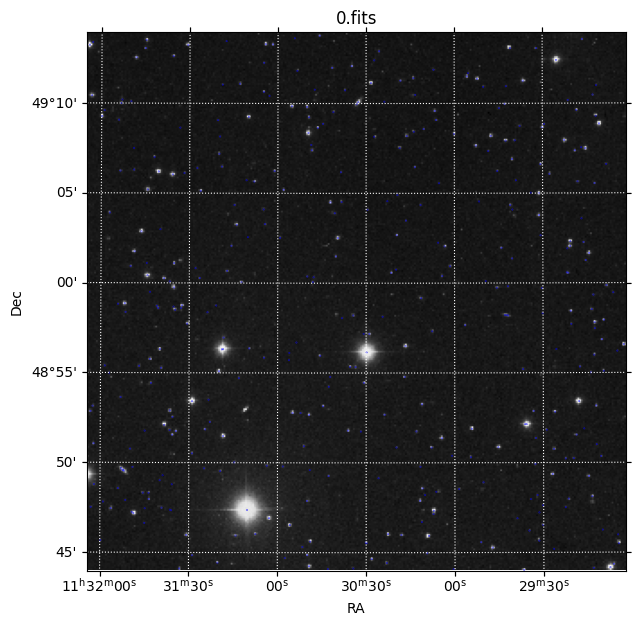

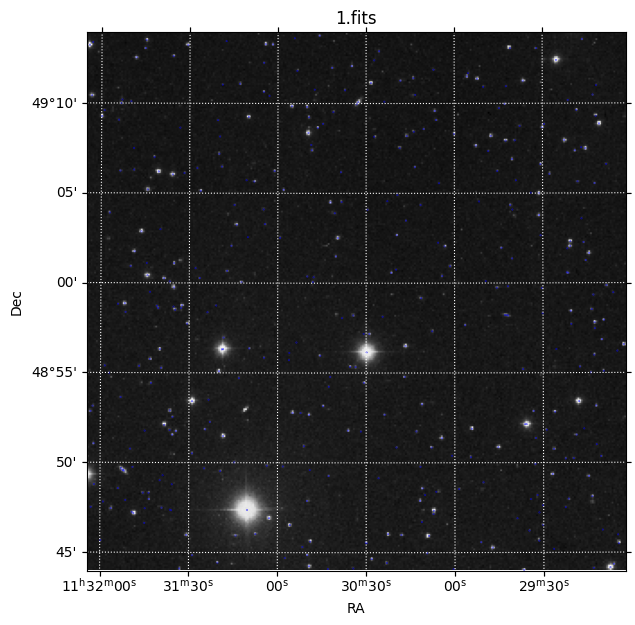

In [12]:
n = 1

for i in range(n):

    filename = i
    file_path = 'data/' + str(i) + '.fits'
    attempts = 0

    while attempts < 1:
        try:
            ra = random.uniform(0, 360)
            dec = random.uniform(-90, 90)
            coords = SkyCoord(ra, dec, unit='deg', frame='icrs')
            coords = SkyCoord(ra=172.63903944*u.deg, dec=48.98346557*u.deg, frame='icrs')


            print('SkyView')        #DEBUG


            # Fetch image data from SkyView
            image_list = SkyView.get_images(position=coords, survey=['DSS'], radius=0.25 * u.deg)

            # Extract the image data from the list
            image_hdu = image_list[0][0]
            image = image_list[0][0].data

            # Extract WCS information from image
            wcs = WCS(image_hdu.header)


            print('Vizier')        #DEBUG


            # Fetch star data from Vizier using the 2MASS catalog
            v = Vizier(columns=['*'])
            v.ROW_LIMIT = -1
            catalog_list = v.query_region(coords, radius=0.35 * u.deg, catalog='II/246')
            catalog = catalog_list[0]




            print('Save')        #DEBUG



            # Save the image as a FITS file
            image_hdu = fits.PrimaryHDU(image)
            hdul = fits.HDUList([image_hdu])
            hdul.writeto(file_path, overwrite=True)

            print('Break')        #DEBUG

            break

        except HTTPError as e:
            if e.code == 404:
                print(f"HTTP Error 404: Not Found. Generating new coordinates and retrying...)")
                attempts += 1
            else:
                raise e  # Re-raise the exception if it's not a 404 error
        except Exception as e:
            print(f"An error occurred: {e}. Generating new coordinates and retrying...)")
            attempts += 1
    # raise RuntimeError(f"Failed to fetch and save data after {attempts} attempts.")



    print('Save Catalog')        #DEBUG


    # Save the star catalog
    with fits.open(file_path, mode='update') as hdul:
        # Sanitize the header if necessary
        sanitized_catalog = Table(catalog, meta=sanitize_header(catalog.meta))
        
        # Create a binary table HDU for the star catalog
        star_hdu = fits.BinTableHDU(sanitized_catalog, name='STAR_CATALOG')
        
        # Append the star catalog HDU to the FITS file
        hdul.append(star_hdu)
        hdul.flush()

    coord_range = getCoordRangeFromPixels(wcs)

    # NOTE: X Max and min are reversed for some reason.. orientation of image in coord system...?

    # x_max = range['lower_left'][0]
    # x_min = range['lower_right'][0]

    # y_min = range['lower_left'][1]
    # y_max = range['upper_left'][1]


    # Convert the table to a pandas DataFrame for easier manipulation
    catalog = catalog.to_pandas()


    stars_in_image = getStarsInImage(wcs, catalog, coord_range)
    # print("Stars in image: ", stars_in_image)
    print("Number of cataloged stars in image: ", len(stars_in_image))

    pixel_coords = getPixelCoordsFromStar(stars_in_image[1])

    # Display the image with the location of the star above circled

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection=wcs)

    x_dim = wcs.pixel_shape[0] # May need to swap x and y dim! (but I think it's right...)
    y_dim = wcs.pixel_shape[1]

    # Pixel-mask of stars
    pixel_mask = np.zeros((x_dim, y_dim))



    print('Drawing')        #DEBUG



    for star in stars_in_image: 

        pixel_coords = getPixelCoordsFromStar(star)
        pixel_mask[int(np.floor(pixel_coords[0]))][int(np.floor(pixel_coords[1]))] = 1

        # print('PIXEL COORDS: ', pixel_coords)

        Drawing_colored_circle = plt.Circle(( pixel_coords[0] , pixel_coords[1] ), 0.1, fill=False, edgecolor='Blue')
        ax.add_artist( Drawing_colored_circle )
        ax.set_title(f'{filename}.fits')
        ax.set_xlabel('RA')
        ax.set_ylabel('Dec')
        ax.grid(color='white', ls='dotted')

    star_overlay = ax.imshow(image_hdu.data, cmap='gray', origin='lower')
    star_overlay

    # with fits.open(file_path, mode='update') as hdul:
    #     hdu = fits.ImageHDU(star_overlay, name='star_overlay')
    #     hdul.append(star_hdu)

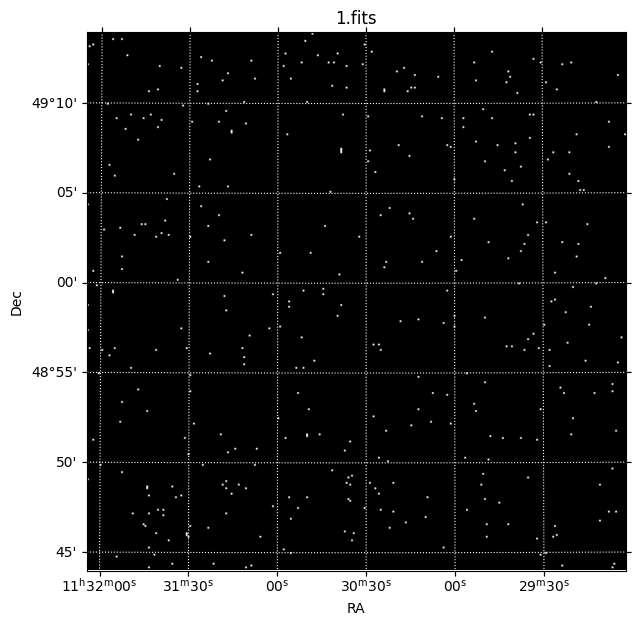

In [16]:
# Display the pixel mask 

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection=wcs)

ax.imshow(pixel_mask, cmap='gray', origin='lower')
ax.set_title(f'{filename}.fits')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.grid(color='white', ls='dotted')